In [61]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import pandas as pd
import json
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import load_model
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.layers import LSTM
#from tensorflow.keras.callbacks import TensorBoard

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM

import settings
import tools
import graphs
import ml_tools

In [62]:
with open('lstm_config.json') as config_file:
    conf = json.load(config_file)

In [63]:
data = pd.read_excel('full_data.xlsx', sheet_name='data')
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)
data = data.astype(float)
#data = data['ENERGY']
data[conf["y_var"]].astype(float)
#data.plot(subplots = True)
#data_u = np.concatenate((data[out_var].values,np.flipud(data[out_var].values)))#duplicado y flipiado
data_u = data[conf["y_var"]].values

In [64]:
data_u, data_mean, data_std = ml_tools.normaize(data_u)
print(data_mean)
print(data_std)
train_split= ml_tools.data_split(data_u, conf["split_p"])

u_past_hist= conf["past_hist"]
u_future_traget = conf["future_target"]

x_train, y_train = ml_tools.univariate_data(data_u, 0, train_split, u_past_hist, u_future_traget)
x_val, y_val = ml_tools.univariate_data(data_u, train_split, None, u_past_hist, u_future_traget)


2761.0948208722743
3630.2230673681306


In [65]:
model = Sequential()
model.add(LSTM(conf["lstm1"], input_shape=x_train.shape[-2:]))
model.add(Dense(1))
#tensorboard = TensorBoard(log_dir= ".logs/{}".format(time.time()))
model.compile(optimizer='adam', loss=conf["loss"], metrics=[conf["metrics"]])
#model.compile(optimizer='adam', loss=conf["loss"])
print(model.summary())
m_perf = model.fit(x_train, y_train, batch_size = conf["batch_size"], epochs= conf["epoch"], shuffle = False, validation_data = (x_val, y_val))
#m_perf = model.fit(x_train, y_train, batch_size = conf["batch_size"], epochs= conf["epoch"], shuffle = False, validation_data = (x_val, y_val), callbacks=[tensorboard])
model.save(settings.m_path+'lstm_u.h5')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 120)               58560     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
None
Train on 4550 samples, validate on 442 samples
Epoch 1/10
4550/4550 [==============================] - 9s 2ms/step - loss: 0.7092 - mse: 0.7346 - mae: 0.7092 - mape: 89.2788 - cosine: 0.5429 - val_loss: 0.5532 - val_mse: 0.5015 - val_mae: 0.5532 - val_mape: 93.7946 - val_cosine: 0.8507
Epoch 2/10
4550/4550 [==============================] - 8s 2ms/step - loss: 0.3915 - mse: 0.2451 - mae: 0.3915 - mape: 86.0329 - cosine: 0.7745 - val_loss: 0.3322 - val_mse: 0.2276 - val_mae: 0.3322 - val_mape: 152.8802 

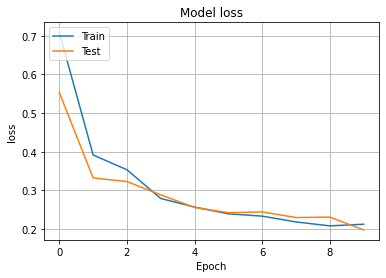

In [66]:
graphs.plot_model_metric(m_perf, 'loss', True)

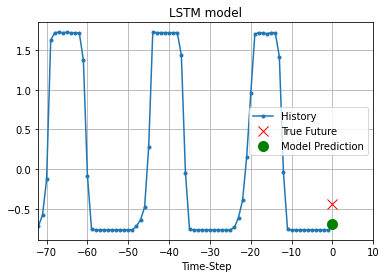

In [67]:
yhat= model.predict(x_val)
#yhat = [y[0] for y in model.predict(x_val)]

it = 17
graphs.show_plot([x_val[it], y_val[it], yhat[it]], 0,'LSTM model')

In [68]:
yhat = ml_tools.desnormalize(yhat, data_mean, data_std)
yhat = ml_tools.model_out_tunep(yhat)
print(data_mean)

2761.0948208722743


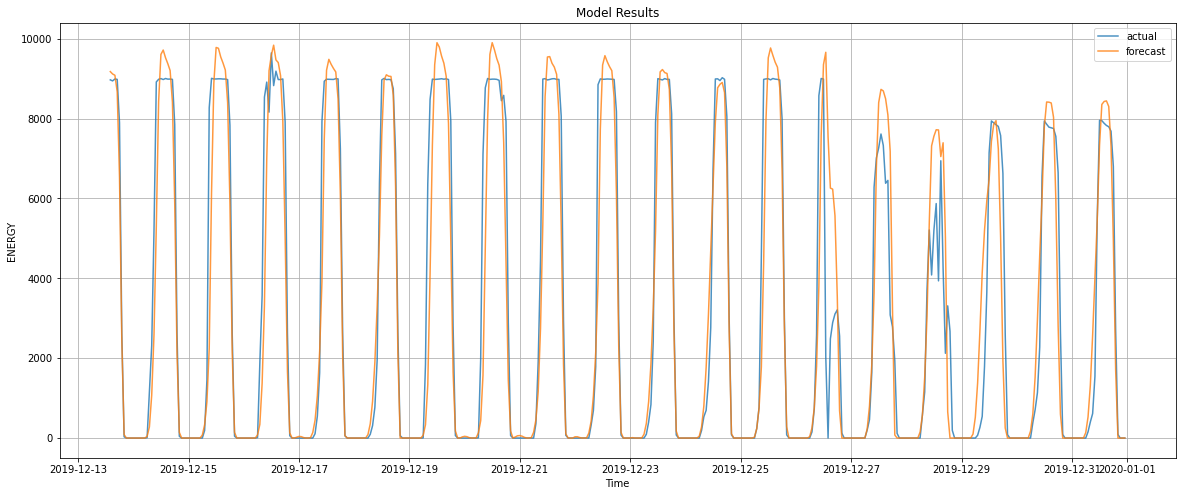

In [69]:
graphs.plot_model_learn(data, yhat)

Predecir N Valores

In [70]:
u_past_hist= conf["past_hist"]
u_future_traget = conf["future_target"]

train_split= ml_tools.data_split(data_u, 100)

x_train, y_train = ml_tools.univariate_data(data_u, 0, train_split, u_past_hist, u_future_traget)

In [71]:
model = Sequential()
model.add(LSTM(conf["lstm1"], input_shape=x_train.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam', loss=conf["loss"])
m_perf = model.fit(x_train, y_train, batch_size = conf["batch_size"], epochs= conf["epoch"], shuffle = False)

Epoch 1/10
5064/5064 [==============================] - 10s 2ms/step - loss: 0.7226
Epoch 2/10
5064/5064 [==============================] - 9s 2ms/step - loss: 0.3743
Epoch 3/10
5064/5064 [==============================] - 9s 2ms/step - loss: 0.3173
Epoch 4/10
5064/5064 [==============================] - 8s 2ms/step - loss: 0.2773
Epoch 5/10
5064/5064 [==============================] - 8s 2ms/step - loss: 0.2538
Epoch 6/10
5064/5064 [==============================] - 8s 2ms/step - loss: 0.2392
Epoch 7/10
5064/5064 [==============================] - 8s 2ms/step - loss: 0.2303
Epoch 8/10
5064/5064 [==============================] - 8s 2ms/step - loss: 0.2179
Epoch 9/10
5064/5064 [==============================] - 8s 2ms/step - loss: 0.2160
Epoch 10/10
5064/5064 [==============================] - 8s 2ms/step - loss: 0.2246


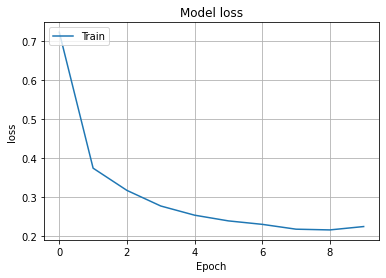

In [72]:
graphs.plot_model_metric(m_perf, 'loss', save = True)

In [73]:
n_ahead = conf["n_ahead"]
last_input= x_train[-1]

In [74]:
yhat = ml_tools.predict_n_ahead(model, n_ahead, last_input)

In [75]:
yhat = ml_tools.desnormalize(np.array(yhat), data_mean, data_std)

In [76]:
yhat = ml_tools.model_out_tunep(yhat)

history
forecast


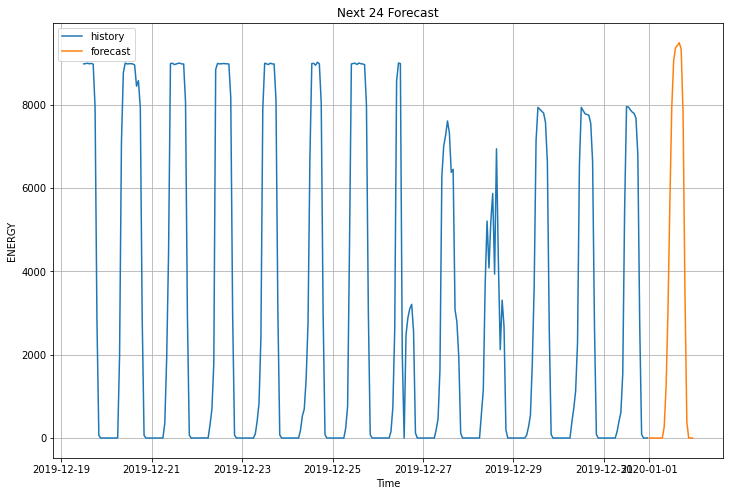

In [77]:
graphs.plot_next_forecast(data, yhat, n_ahead)

In [78]:
fc = ml_tools.forecast_dataframe(data, yhat, n_ahead)
fc =fc.iloc[-49:]
print(fc)

          ENERGY      type            DateTime
275     0.000000   history 2019-12-30 23:00:00
276     0.000000   history 2019-12-31 00:00:00
277     0.000000   history 2019-12-31 01:00:00
278     0.000000   history 2019-12-31 02:00:00
279     0.000000   history 2019-12-31 03:00:00
280     0.000000   history 2019-12-31 04:00:00
281     0.000000   history 2019-12-31 05:00:00
282     0.000000   history 2019-12-31 06:00:00
283   156.000000   history 2019-12-31 07:00:00
284   402.000000   history 2019-12-31 08:00:00
285   612.000000   history 2019-12-31 09:00:00
286  1546.000000   history 2019-12-31 10:00:00
287  5514.000000   history 2019-12-31 11:00:00
288  7956.000000   history 2019-12-31 12:00:00
289  7948.000000   history 2019-12-31 13:00:00
290  7882.000000   history 2019-12-31 14:00:00
291  7828.000000   history 2019-12-31 15:00:00
292  7796.000000   history 2019-12-31 16:00:00
293  7684.000000   history 2019-12-31 17:00:00
294  6798.000000   history 2019-12-31 18:00:00
295  2718.000